# Analysis of Results
* Results were computed in `Evaluation.ipynb`
* In this notebook, we play with the results to gain further insights.

In [6]:
import os
from os.path import join
from scripts.scoring import create_matrix_from_csv

res_files = os.listdir('direct_results')
direct_res = {f.replace('.csv', ''):{'file':join('direct_results', f), 'BLEU':None} for f in res_files}

for rs, content in direct_res.items():
    file_path = content['file']
    df = create_matrix_from_csv(file_path)
    direct_res[rs]['BLEU'] = df
    
    
res_files = os.listdir('post_results')
post_res = {f.replace('.csv', ''): {'file': join(
    'post_results', f), 'BLEU': None, 'CHRF':None} for f in res_files}

for rs, content in post_res.items():
    file_path = content['file']
    df_bleu = create_matrix_from_csv(file_path)
    df_chrf = create_matrix_from_csv(file_path, metric='chrF')
    post_res[rs]['BLEU'] = df_bleu
    post_res[rs]['CHRF'] = df_chrf

## Pearson Correlation

* Correlation between both translators
* We perform this on the direct aligned and post aligned results
    * Direct: We literally computed BLEU scores directly on the translation, without doing any alignments.
    * Post: We applied `bertalign` and sentence splitting to align everything nicely.

In [7]:
import numpy as np
from scipy.stats import pearsonr

parts = ['ep', 'flores', 'opus']

print('direct_results')
for part in parts:
    gpt = f'{part}-gpt'
    deepl = f'{part}-deepl'
    gpt_df = direct_res[gpt]['BLEU']
    deepl_df = direct_res[deepl]['BLEU']

    # flattens whole matrix into 1D-array
    gpt_flat = gpt_df.values.flatten()
    deepl_flat = deepl_df.values.flatten()

    mask = ~np.isnan(gpt_flat) & ~np.isnan(deepl_flat)

    # Compute Pearson correlation
    corr, pval = pearsonr(gpt_flat[mask], deepl_flat[mask])
    print(part)
    print(f"Pearson correlation: {corr:.2f}")
    print(f"p-value: {pval:.3f}")
    print()
    
print('post_results')
for part in parts:
    gpt = f'{part}-gpt'
    deepl = f'{part}-deepl'
    gpt_df = post_res[gpt]['BLEU']
    deepl_df = post_res[deepl]['BLEU']

    gpt_flat = gpt_df.values.flatten()
    deepl_flat = deepl_df.values.flatten()

    mask = ~np.isnan(gpt_flat) & ~np.isnan(deepl_flat)

    # Compute Pearson correlation
    corr, pval = pearsonr(gpt_flat[mask], deepl_flat[mask])
    print(part)
    print(f"Pearson correlation: {corr:.2f}")
    print(f"p-value: {pval:.3f}")
    print()

direct_results
ep
Pearson correlation: 0.61
p-value: 0.000

flores
Pearson correlation: 0.80
p-value: 0.000

opus
Pearson correlation: 0.30
p-value: 0.206

post_results
ep
Pearson correlation: 0.93
p-value: 0.000

flores
Pearson correlation: 0.96
p-value: 0.000

opus
Pearson correlation: 0.96
p-value: 0.000



* Observe, statistical significance went up after alignment, especially for OPUS100

* Next, we compute correlation between BLEU and CHRF scores.

In [31]:
import numpy as np
from scipy.stats import pearsonr

parts = ['ep', 'flores', 'opus']
translators = ['deepl', 'gpt']

for part in parts:
    for tl in translators:
        key = f'{part}-{tl}'
        bleu_mat = post_res[key]['BLEU']
        chrf_mat = post_res[key]['CHRF']
        
        
        bleu_flat = bleu_mat.values.flatten()
        chrf_flat = chrf_mat.values.flatten()

        mask = ~np.isnan(bleu_flat) & ~np.isnan(chrf_flat)

        # Compute Pearson correlation
        corr, pval = pearsonr(bleu_flat[mask], chrf_flat[mask])
        print(part, tl)
        print(f"Pearson correlation: {corr:.2f}")
        print(f"p-value: {pval:.5f}")
        print()

ep deepl
Pearson correlation: 0.83
p-value: 0.00000

ep gpt
Pearson correlation: 0.87
p-value: 0.00000

flores deepl
Pearson correlation: 0.94
p-value: 0.00000

flores gpt
Pearson correlation: 0.95
p-value: 0.00000

opus deepl
Pearson correlation: 0.85
p-value: 0.00000

opus gpt
Pearson correlation: 0.88
p-value: 0.00000



### Plotting

* Let's do some graphing on EuroParl, DeepL, has the lowest Pearson correlation compared to the others

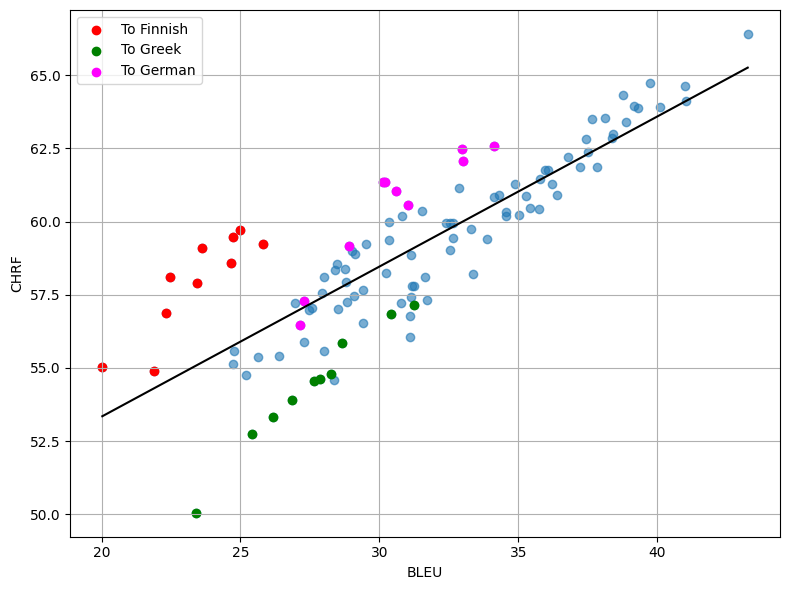

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
bleu = post_res['ep-deepl']['BLEU']
chrf = post_res['ep-deepl']['CHRF']

bleu_vals, chrf_vals = [], []
labels = []

for src in bleu.index:
    for tgt in bleu.columns:
        if src==tgt:
            continue
        bs = bleu.loc[src, tgt]
        cs = chrf.loc[src, tgt]
        bleu_vals.append(bs)
        chrf_vals.append(cs)
        labels.append(f'{src}-{tgt}')


bleu_vals_np = np.array(bleu_vals)
chrf_vals_np = np.array(chrf_vals)


# Plot all points
plt.figure(figsize=(8, 6))
plt.scatter(bleu_vals, chrf_vals, alpha=0.6)

model = np.polyfit(bleu_vals_np, chrf_vals_np, 1)


to_finnish = [idx for idx, pair in enumerate(labels) if pair.endswith('fi')]
to_greek = [idx for idx, pair in enumerate(labels) if pair.endswith('el')]
to_german = [idx for idx, pair in enumerate(labels) if pair.endswith('de')]

plt.scatter(
    bleu_vals_np[to_finnish],
    chrf_vals_np[to_finnish],
    color='red',
    label='To Finnish'
)

plt.scatter(
    bleu_vals_np[to_greek],
    chrf_vals_np[to_greek],
    color='green',
    label='To Greek'
)

plt.scatter(
    bleu_vals_np[to_german],
    chrf_vals_np[to_german],
    color='magenta',
    label='To German'
)



x_line = np.linspace(min(bleu_vals_np), max(bleu_vals_np), 100)
y_line = model[0] * x_line + model[1]
plt.plot(x_line, y_line, color='black')


plt.xlabel("BLEU")
plt.ylabel("CHRF")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
predicted_chrf = model[0] * bleu_vals_np + model[1]
residuals = abs(chrf_vals_np - predicted_chrf)

threshold = 3
outlier_indices = np.where(residuals > threshold)[0]

# Or get top N residuals
top_n = 20
outlier_indices = np.argsort(residuals)[-top_n:]

In [45]:
for idx in outlier_indices:
    print(f"{labels[idx]} {bleu_vals_np[idx]:.1f}, {chrf_vals_np[idx]:.2f}")

sv-fi 22.3, 56.87
es-de 33.0, 62.50
fr-el 27.6, 54.55
sv-el 27.9, 54.63
da-el 28.3, 54.79
el-de 30.2, 61.36
pt-fi 23.4, 57.89
fr-de 30.1, 61.37
de-fi 24.7, 58.59
da-fi 25.8, 59.23
de-el 26.9, 53.89
nl-es 31.1, 56.04
nl-pt 28.4, 54.58
it-el 26.2, 53.31
fi-el 25.4, 52.74
fr-fi 22.4, 58.09
en-fi 24.7, 59.46
es-fi 25.0, 59.71
el-fi 23.6, 59.11
nl-el 23.4, 50.05


* Iterative process, this was done first, then To German, To Finnish and To Greek pairs were marked.